=== 优化后评估指标 ===
LSA Silhouette Score: 0.0370
LSA Kappa Score: 0.3987


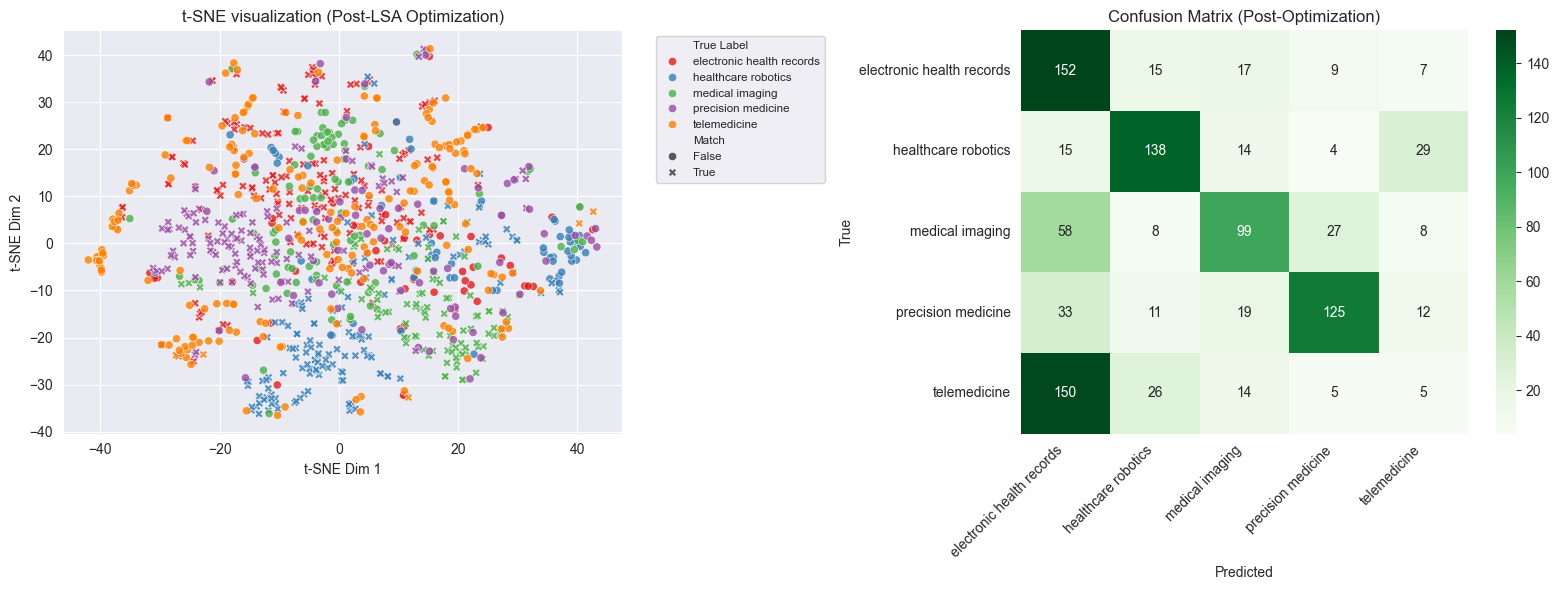

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE

# ----------------- 1. 数据读取与基础清理 -----------------
df = pd.read_csv('../processed_data.csv')
docs = df['Cleaned_Content'].fillna('').str.replace(r'\bpad\b', '', regex=True).tolist()
true_labels = df['Label'].tolist()

unique_labels = sorted(list(set(true_labels)))
label_to_id = {l: i for i, l in enumerate(unique_labels)}
y_true = [label_to_id[l] for l in true_labels]

# ----------------- 2. 进阶特征工程 (TF-IDF + LSA) -----------------
# 2.1 引入在误差分析中发现的"高频噪音词"作为定制停用词
# 这些词在所有医学文献中都大量出现，干扰了特定子领域的聚类
custom_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + \
                    ['patient', 'data', 'study', 'health', 'method', 'model',
                     'clinical', 'based', 'using', 'healthcare', 'care', 'result', 'analysis']

# 限制 max_df 以去除过于普遍的词汇，增加 min_df 去除极其生僻的词汇
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stop_words, max_df=0.6, min_df=5)
X_tfidf = tfidf_vectorizer.fit_transform(docs)

# 2.2 潜在语义分析 (LSA) - 使用 TruncatedSVD 降维
# 将 5000 维的稀疏矩阵降维至 100 维的稠密语义向量空间
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)

# ----------------- 3. K-means 聚类 (基于语义向量) -----------------
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20) # 增加 n_init 避免局部最优
y_pred_clusters = kmeans.fit_predict(X_lsa)

# 匈牙利算法匹配标签
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    y_pred_matched = [mapping[l] for l in y_pred]
    return np.array(y_pred_matched), mapping, cm

y_pred_matched, cluster_mapping, cm = match_labels(y_true, y_pred_clusters)

# ----------------- 4. 模型评估 -----------------
sil_score = silhouette_score(X_lsa, y_pred_clusters)
kappa = cohen_kappa_score(y_true, y_pred_matched)

print(f"=== 优化后评估指标 ===")
print(f"LSA Silhouette Score: {sil_score:.4f}")
print(f"LSA Kappa Score: {kappa:.4f}")

# ----------------- 5. 结果可视化 -----------------
plt.figure(figsize=(16, 6))

# 图1: t-SNE 降维散点图 (基于优化后的 LSA 向量)
plt.subplot(1, 2, 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_lsa)
df_tsne = pd.DataFrame({
    't-SNE Dim 1': X_tsne[:,0],
    't-SNE Dim 2': X_tsne[:,1],
    'True Label': [unique_labels[i] for i in y_true],
    'Match': y_true == y_pred_matched
})
sns.scatterplot(data=df_tsne, x='t-SNE Dim 1', y='t-SNE Dim 2', hue='True Label', style='Match', palette='Set1', alpha=0.8)
plt.title('t-SNE visualization (Post-LSA Optimization)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# 图2: 混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_true, y_pred_matched), annot=True, fmt='d', cmap='Greens',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix (Post-Optimization)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('clustering_eval_optimized.png', dpi=300)
plt.show()